# <center> [Adult salaries](https://archive.ics.uci.edu/ml/datasets/adult): Decission tree
### <center>Predict whether income exceeds $50K/yr based on census data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# Leer CSV

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
#!wget -P ./../data/ https://raw.githubusercontent.com/SaturdaysAI-Murcia/machine-learning/master/data/adult.csv

In [3]:
df = pd.read_csv("../data/adult.csv")

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


# EDA

In [17]:
ProfileReport(df)

# Warnings:

- **Missings**
  - Cabin has 687 (77.1%) missing values
  - Age has 177 (19.9%) missing values
- **Zeros**
  - Parch has 678 (76.1%) zeros
  - SibSp has 608 (68.2%) zeros
  - Fare has 15 (1.7%) zeros
- **High cardinality**
  - Name has a high cardinality: 891 distinct values
  - Ticket has a high cardinality: 681 distinct values
  - Cabin has a high cardinality: 148 distinct values

# Qué queremos predecir? -> `df.Survived`

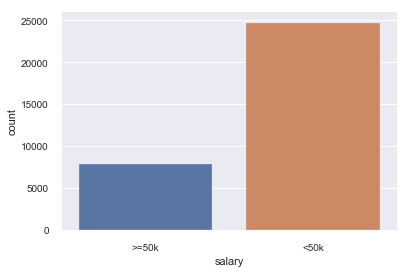

In [5]:
sns.countplot(df.salary);

# Con que métrica se evalua? -> [Accucy](https://www.kaggle.com/c/titanic/overview/evaluation)

In [7]:
from sklearn.metrics import accuracy_score
pred = [0, 0, 1, 1]
true = [0, 1, 1, 1]
accuracy_score(true, pred)

0.75

# Consejo de Andrés: Elegir bien el conjunto de validación

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Modelo 1: Decission Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

x = df[['age', 'workclass', #'fnlwgt', 'education', 'education-num',
       #'marital-status', 'occupation', 'relationship', 'race', 'sex',
       #'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'
       ]]
y = df["salary"]
model1 = DecisionTreeClassifier()
model1.fit(x, y)

ValueError: could not convert string to float: ' Private'

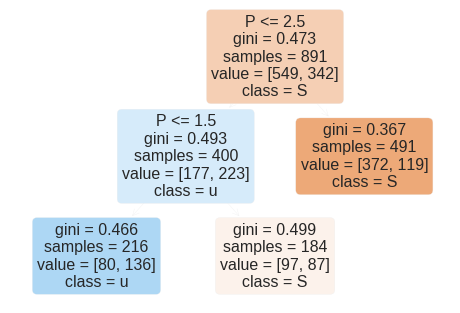

In [24]:
from sklearn import tree
tree.plot_tree(model1, feature_names="Pclass", class_names="Survived", filled=True, rounded=True);